In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Importing Data and Adjusting Data Labels

In [3]:
df = pd.read_csv('/home/hasan/Projects/heme_gpt/gpt_heme_diff_output_v7_split.csv')
df['Dx_Cat'] = df['Dx_Cat'].str.replace('Acute Myeloid Leukemia/Acute Lymphoblastic Leukemia', 'AML/ALL')
df['Diagnosis Category 1'] = df['Diagnosis Category 1'].str.replace('Acute Myeloid Leukemia/Acute Lymphoblastic Leukemia', 'AML/ALL')
df['Diagnosis Category 2'] = df['Diagnosis Category 2'].str.replace('Acute Myeloid Leukemia/Acute Lymphoblastic Leukemia', 'AML/ALL')
df['Diagnosis Category 3'] = df['Diagnosis Category 3'].str.replace('Acute Myeloid Leukemia/Acute Lymphoblastic Leukemia', 'AML/ALL')

In [4]:
df = df[df['Conclusion'] != 'NO']

### Creating Confusion Matrix from Top-1 Diagnoses

In [42]:
y_true = df['Dx_Cat']
y_pred = df['Diagnosis Category 1']
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_prop = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

### Plotting the Confusion Matrix using Seaborn

In [43]:
plt.figure(figsize=(10, 9))
sns.heatmap(conf_matrix_prop, annot=True, fmt='.2f', cmap='flare', vmin=0, vmax=1, xticklabels=sorted(df['Dx_Cat'].unique()), yticklabels=sorted(df['Dx_Cat'].unique()))
plt.title('Normalized Confusion Matrix for GPT4 predictions for Hematological Disease, by Category')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f'normalized_CM.png', format='png', dpi=300, bbox_inches='tight')
plt.close() 

### Defining function to calculate Accuracy, Precision, Recall and F-Score for each Top-k prediction for each Label

In [28]:
def calculate_metrics(df):
    unique_labels = df['Dx_Cat'].unique()
    metrics = {label: {'Top-1': {}, 'Top-2': {}, 'Top-3': {}} for label in unique_labels}

    for label in unique_labels:
        total_instances = df[df['Dx_Cat'] == label].shape[0]
        for top_k in ['Top-1', 'Top-2', 'Top-3']:
            top_k_index = int(top_k.split('-')[1])  

            if top_k_index == 1:
                TP = df[(df['Dx_Cat'] == label) & (df['Diagnosis Category 1'] == label)].shape[0]
            else:
                TP_conditions = [(df['Dx_Cat'] == label) & (df[f'Diagnosis Category {i}'] == label) for i in range(1, top_k_index + 1)]
                TP = df[np.logical_or.reduce(TP_conditions)].shape[0]

            if top_k_index == 1:
                FP = df[(df['Diagnosis Category 1'] == label) & (df['Dx_Cat'] != label)].shape[0]
            else:
                FP_conditions = [(df[f'Diagnosis Category {i}'] == label) & (df['Dx_Cat'] != label) for i in range(1, top_k_index + 1)]
                FP = df[np.logical_or.reduce(FP_conditions)].shape[0]

            if top_k_index == 1:
                FN = df[(df['Dx_Cat'] == label) & (df['Diagnosis Category 1'] != label)].shape[0]
            else:
                FN_conditions = [(df['Dx_Cat'] == label) & (df[f'Diagnosis Category {i}'] != label) for i in range(1, top_k_index + 1)]
                FN = df[np.logical_and.reduce(FN_conditions)].shape[0]

            Precision = TP / (TP + FP) if TP + FP > 0 else 0
            Recall = TP / (TP + FN) if TP + FN > 0 else 0
            F_Score = 2 * (Precision * Recall) / (Precision + Recall) if Precision + Recall > 0 else 0

            Accuracy = TP / (TP + FN) if (TP + FN) > 0 else 0

            metrics[label][top_k] = {
                'Precision': Precision,
                'Recall': Recall,
                'F-Score': F_Score,
                'TP': TP,
                'FP': FP,
                'FN': FN,
                'Accuracy': Accuracy,
                'Total Instances': total_instances
            }

    return metrics

In [29]:
metrics = calculate_metrics(df)
print(metrics)

{'AML/ALL': {'Top-1': {'Precision': 0.8469945355191257, 'Recall': 1.0, 'F-Score': 0.9171597633136095, 'TP': 155, 'FP': 28, 'FN': 0, 'Accuracy': 1.0, 'Total Instances': 155}, 'Top-2': {'Precision': 0.7989690721649485, 'Recall': 1.0, 'F-Score': 0.8882521489971347, 'TP': 155, 'FP': 39, 'FN': 0, 'Accuracy': 1.0, 'Total Instances': 155}, 'Top-3': {'Precision': 0.6981981981981982, 'Recall': 1.0, 'F-Score': 0.8222811671087533, 'TP': 155, 'FP': 67, 'FN': 0, 'Accuracy': 1.0, 'Total Instances': 155}}, 'Chronic Lymphocytic Leukemia': {'Top-1': {'Precision': 0.23684210526315788, 'Recall': 0.75, 'F-Score': 0.36, 'TP': 9, 'FP': 29, 'FN': 3, 'Accuracy': 0.75, 'Total Instances': 12}, 'Top-2': {'Precision': 0.19148936170212766, 'Recall': 0.75, 'F-Score': 0.3050847457627119, 'TP': 9, 'FP': 38, 'FN': 3, 'Accuracy': 0.75, 'Total Instances': 12}, 'Top-3': {'Precision': 0.17647058823529413, 'Recall': 0.75, 'F-Score': 0.2857142857142857, 'TP': 9, 'FP': 42, 'FN': 3, 'Accuracy': 0.75, 'Total Instances': 12}}, 

### Plotting the model's evaluation metrics for each diagnosis label

In [30]:
def plot_metrics(label, metrics):
    data = []
    for top_k, values in metrics.items():
        for eval_metric in ['Accuracy', 'Precision', 'Recall', 'F-Score']:
            value = values[eval_metric]
            data.append({'Top-k Prediction': top_k, 'Value': value, 'Evaluation': eval_metric})
    
    df = pd.DataFrame(data)


    fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True) 
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  

    colors = ['#E77E63', '#C14068', '#6A2B6C']

    for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F-Score']):
        ax = axes[i//2, i%2]
        metric_df = df[df['Evaluation'] == metric]

        for j, top_k in enumerate(metric_df['Top-k Prediction'].unique()):
            sns.barplot(x='Top-k Prediction', y='Value', data=metric_df[metric_df['Top-k Prediction'] == top_k], ax=ax, color=colors[j], label=top_k)
        ax.set_ylim(0, 1) 
        ax.set_title(f'{label} - {metric}')
        ax.set_ylabel('Score')
        ax.legend().remove()  

    plt.tight_layout()
    safe_label = label.replace("/", "_").replace(" ", "_")


    plt.savefig(f'figures/{safe_label}_metrics.png', format='png', dpi=300)
    plt.close() 

In [31]:
for label, label_metrics in metrics.items():
    plot_metrics(label, label_metrics)

### Writing Metrics Data into a Table

In [34]:
data = []
for label, top_k_data in metrics.items():
    for top_k, values in top_k_data.items():
        row = {
            'Label': label,
            'Top-k': top_k,
            'Accuracy': values['Accuracy'],
            'Precision': values['Precision'],
            'Recall': values['Recall'],
            'F-Score': values['F-Score'],
            'TP': values['TP'],
            'FP': values['FP'],
            'FN': values['FN'],
            'Total Instances': values['Total Instances']
        }
        data.append(row)

metrics_df = pd.DataFrame(data)
metrics_df.to_csv('table1.csv', index=False)

### Checking which type of FLOW the model suggested

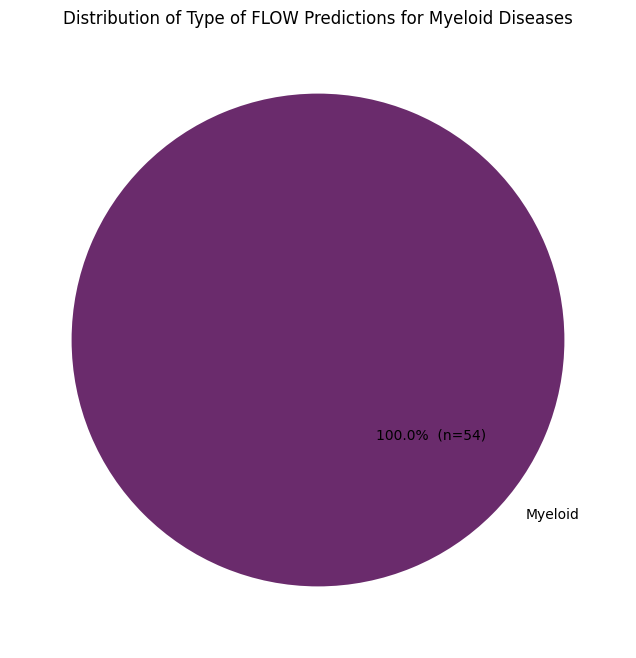

In [60]:
#filtered_df = df[df['Dx_Cat'].isin(['Chronic Lymphocytic Leukemia', 'Mature B-cell Neoplasm'])]
filtered_df = df[df['Dx_Cat'].isin(['Chronic Myeloid Leukemia', 'Chronic Myelomonocytic Leukemia'])]

flow_counts = filtered_df['Type of FLOW'].value_counts()

category_colors = {
    'Lymphoid': '#E77E63',
    'Myeloid': '#6A2B6C'
}

pie_colors = [category_colors[label] for label in flow_counts.index]

def custom_autopct(pct):
    total = sum(flow_counts)
    val = int(round(pct*total/100.0))
    return '{p:.1f}%  (n={v:d})'.format(p=pct, v=val)

plt.figure(figsize=(8, 8))
plt.pie(flow_counts, labels=flow_counts.index, autopct=custom_autopct, startangle=140, colors=pie_colors)
plt.title('Distribution of Type of FLOW Predictions for Myeloid Diseases')
plt.savefig(f'figures/myeloid_FLOW_predictions.png', format='png', dpi=300)
plt.show()